<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-fitting" data-toc-modified-id="Model-fitting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model fitting</a></span></li><li><span><a href="#Prior-distribution" data-toc-modified-id="Prior-distribution-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prior distribution</a></span></li><li><span><a href="#Logistic-fits" data-toc-modified-id="Logistic-fits-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Logistic fits</a></span></li><li><span><a href="#Threshold---Gain-plot" data-toc-modified-id="Threshold---Gain-plot-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Threshold - Gain plot</a></span></li><li><span><a href="#Threshold---Asymmetry-plot" data-toc-modified-id="Threshold---Asymmetry-plot-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Threshold - Asymmetry plot</a></span></li><li><span><a href="#slope-vs-density" data-toc-modified-id="slope-vs-density-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>slope vs density</a></span></li><li><span><a href="#plot-half-ot-the-gain-and-r-star" data-toc-modified-id="plot-half-ot-the-gain-and-r-star-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>plot half ot the gain and r-star</a></span></li><li><span><a href="#thresholds-&amp;-density" data-toc-modified-id="thresholds-&amp;-density-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>thresholds &amp; density</a></span></li></ul></div>

# Model fitting

```
$ python fit_sigmoids.py
$ python fitting_models.py
```



# Prior distribution

In [57]:
import os
import pickle as pkl
import numpy as np
import scipy.io as sio
import scipy
from scipy import stats
from scipy.optimize import curve_fit, minimize
import scipy.signal
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch, Polygon
from matplotlib.collections import PatchCollection
from ec_class import value_efficient_coding_moment, juice_magnitudes, juice_prob
use_gamma = False

if use_gamma:
    fig_folder = "figures_gamma"
else:
    fig_folder = "figures"

In [58]:
# local function definitions
def sigmoid_func(x, a, b, c):
    return b / (1 + np.exp(-(x - c) * a))

# get first derivative of the sigmoid function
def first_derivative_sigmoid_func(x, a, b, c):
    return a*b*np.exp(-a*(x-c))/ (1 + np.exp(-a*(x-c)))**2

def log_kde(x, y, sigma, x_sample):
    """ calculates a log-normal based kernel density estimate
    based on samples at x with weights/probabilities y evaluated at x_sample"""
    # mean = exp(mu + sigma^2/2) != mtrue
    # -> mu = log(mtrue) - sigma^2/2
    mu = np.log(x) - (sigma ** 2 / 2)
    y_sample = np.zeros_like(x_sample)
    for mu_i, y_i in zip(mu, y):
        y_sample += (np.exp(-((np.log(x_sample) - mu_i) ** 2) / 2 / (sigma ** 2))
                     / np.sqrt(2 * np.pi) / sigma / x_sample) * y_i
    return y_sample

In [59]:
# load fitted alpha
if use_gamma:
    alpha_dir = "res_alpha_gamma"
    savedir = "res_rstar_slope_rt_gamma"
else:
    alpha_dir = "res_alpha"
    savedir = "res_rstar_slope_rt"
with open(os.path.join(alpha_dir, "res_alpha.pkl"), "rb") as f:
    data = pkl.load(f)
    alpha = data["res"].x

# load fitted r_star and slope_scale
pars = []
loss = []
for i in range(25):
    fname = os.path.join(savedir, "res_rstar_slope_{0}.pkl".format(i))
    if os.path.exists(fname):
        with open(os.path.join(fname), "rb") as f:
            data = pkl.load(f)
            pars.append(data["res"].x)
            loss.append(data["res"].fun)
idx_best = np.argmin(loss)
pars = pars[idx_best]
r_star = pars[0]
slope_scale = pars[1]
R_t = pars[2]

print(alpha) # parameter fitted
print(R_t)
print(r_star)
print(slope_scale)

0.6970501221673365
322.3745970417019
10.103013638708987
5.754807688524227


In [60]:
# load sigmoid fit results
# read './measured_neurons/CurveFit.ipynb' for more info

N_neurons = 39

ec = value_efficient_coding_moment(
    N_neurons=N_neurons, R_t=R_t, alpha=alpha, slope_scale=slope_scale, use_gamma=use_gamma)

ec_simple = value_efficient_coding_moment(
    N_neurons=N_neurons, R_t=R_t, alpha=alpha, slope_scale=slope_scale, simpler=True, use_gamma=use_gamma)
ec_simple.replace_with_pseudo()

dir_measured_neurons = 'measured_neurons/'

NDAT = sio.loadmat(dir_measured_neurons + 'data_max.mat')['dat']
data = sio.loadmat('curve_fit_parameters_min.mat')
# "curve_fit_parameters.mat" is the file that contains logistic fits of neurons
# read './fit_sigmoids.py' for more info

indices = np.setdiff1d(np.linspace(0, 39, 40).astype(np.int16), 19) # except one neuron
param_set = data['ps'][indices]
midpoints = data['ps'][indices,2]

In [61]:
# get asymmatric slopes 
# increase num_samples to int(1e4) 
tf, quantiles_ec, thresh_ec, alphas, xs, ys = ec.plot_approximate_kinky_fromsim_fitting_only_raw_rstar(
    r_star=r_star, num_samples=int(1e4))

In [62]:
# load details from Dabneys paper. refer to `./measured_neurons/dabney_matlab/`
fig5 = sio.loadmat("./measured_neurons/dabney_matlab/dabney_fit.mat")
fig5_betas = sio.loadmat("./measured_neurons/dabney_matlab/dabney_utility_fit.mat")
scaleFactNeg_all = fig5['scaleFactNeg_all'][:, 0]
scaleFactPos_all = fig5['scaleFactPos_all'][:, 0]
asymM_all = fig5['asymM_all'][:, 0]
ZC_true_label = fig5['utilityAxis'].squeeze()
ZC_estimator = lambda x: fig5_betas["betas"][0, 0] + fig5_betas["betas"][1, 0] * x
idx_to_maintain = np.where((scaleFactNeg_all * scaleFactPos_all) > 0)[0]
asymM_all = asymM_all[idx_to_maintain]
asymM_all_save = asymM_all.copy()
idx_sorted = np.argsort(asymM_all)
asymM_all = asymM_all[idx_sorted]
estimated_ = np.array(ec.get_quantiles_RPs(asymM_all))
zero_crossings = fig5['zeroCrossings_all'][:, 0]
zero_crossings = zero_crossings[idx_to_maintain]
zero_crossings = zero_crossings[idx_sorted]
zero_crossings_estimated = ZC_estimator(zero_crossings) # estimated thresholds

In [63]:
true_thresh = sio.loadmat(os.path.join("measured_neurons", "data_max.mat"))["dat"]["ZC"][0, 0].squeeze()

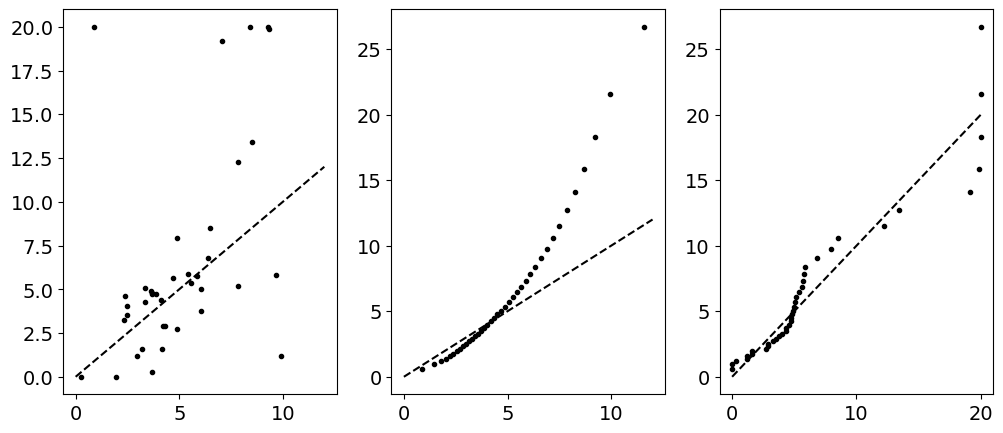

In [64]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
idx_sort = np.argsort(true_thresh)
plt.plot(true_thresh[idx_sort], midpoints[idx_sort], 'k.')
plt.plot([0,12], [0,12], 'k--')
plt.subplot(1,3,2)
#plt.plot(np.sort(thresh_ec), np.sort(pars_ec[:, 2]), 'k.')
plt.plot(np.sort(thresh_ec), np.sort(ec.midpoints), 'k.')
plt.plot([0,12], [0,12], 'k--')
plt.subplot(1,3,3)
plt.plot(np.sort(midpoints), np.sort(ec.midpoints), 'k.')
plt.plot([0,20], [0,20], 'k--')

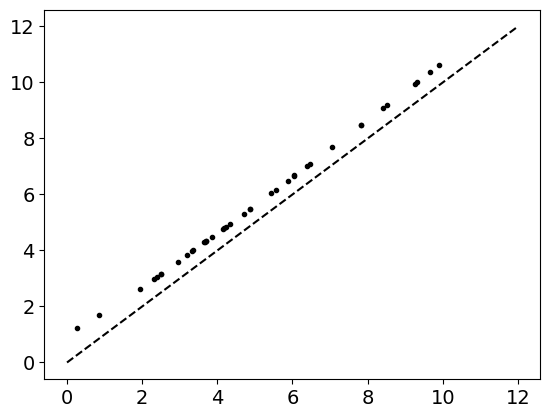

In [65]:
plt.plot(np.sort(true_thresh), np.sort(zero_crossings_estimated), 'k.')
plt.plot([0,12], [0,12], 'k--')

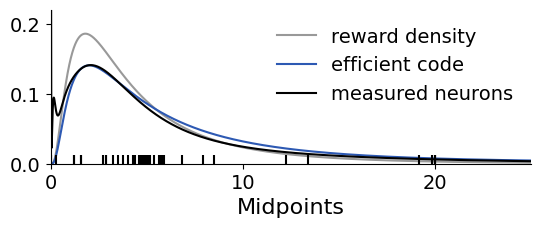

In [66]:
%matplotlib inline 
# Midpoints figure

ys = log_kde(midpoints, np.ones(39)/39, .6, ec.x)
ys *= np.sum(ec.p_prior) / np.sum(ys)

fig,ax = plt.subplots(1,1)

# Reward distribution
plt.plot(ec.x, ec.p_prior, color='#999999')
# Efficient code density
plt.plot(ec.x, ec.d_x, color='#2D59B3')
# kde estimate of real neurons
plt.plot(ec.x, ys,color='k')

# individual neurons
ax.vlines(midpoints, 0, .012*np.ones(midpoints.shape) ,colors='k')
#ax.vlines(ec.sn, -0.012, 0, colors='k')

# Decoration
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0, 25)
ax.set_ylim(0, .22)
ax.set_xticks([0,10,20])
fig.set_figwidth(6.2)
fig.set_figheight(2)
plt.legend(['reward density', 'efficient code', 'measured neurons'], fontsize=14, frameon=False)
plt.xlabel("Midpoints", fontdict={'size':16})

plt.savefig(os.path.join(".", fig_folder, "midpoints.png"),bbox_inches = 'tight')
plt.savefig(os.path.join(".", fig_folder, "midpoints.pdf"),bbox_inches = 'tight')
plt.show()

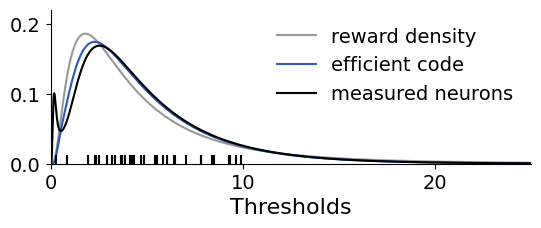

In [67]:
%matplotlib inline 
# Thresholds figure

ys = log_kde(true_thresh, np.ones(39)/39, .5, ec.x)
ys *= np.sum(ec.p_prior) / np.sum(ys)

ys_ec = log_kde(thresh_ec, np.ones(39)/39, .5, ec.x)
ys_ec *= np.sum(ec.p_prior) / np.sum(ys_ec)


fig,ax = plt.subplots(1,1)

# Reward distribution
plt.plot(ec.x, ec.p_prior, color='#999999')
# Efficient code density
plt.plot(ec.x, ys_ec, color='#2D59B3')
# kde estimate of real neurons
plt.plot(ec.x, ys,color='k')

# individual neurons
ax.vlines(true_thresh, 0, .012*np.ones(true_thresh.shape) ,colors='k')
#ax.vlines(ec.sn, -0.012, 0, colors='#2D59B39ebcda')

# Decoration
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0, 25)
ax.set_ylim(0, .22)
ax.set_xticks([0,10,20])
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
fig.set_figwidth(6.2)
fig.set_figheight(2)
plt.legend(['reward density', 'efficient code', 'measured neurons'], fontsize=14, frameon=False)
plt.xlabel("Thresholds", fontdict={'size':16})

plt.savefig(os.path.join('.', fig_folder, 'thresholds.png'), bbox_inches = 'tight')
plt.savefig(os.path.join('.', fig_folder, 'thresholds.pdf'),bbox_inches = 'tight')
plt.show()

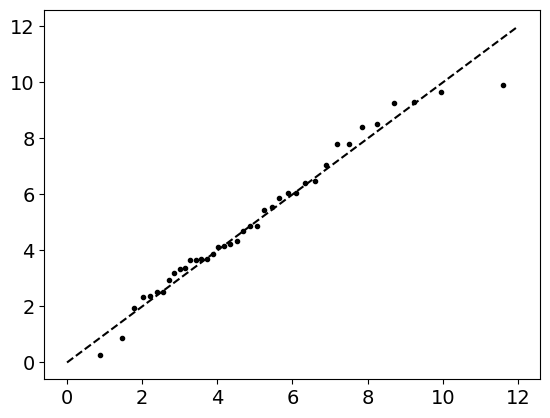

In [68]:
plt.plot(thresh_ec, np.sort(true_thresh), 'k.')
plt.plot([0,12], [0,12], 'k--')

# Logistic fits

As mentioned, "curve_fit_parameters.mat"  contains result of logistic fits of neurons.

Read './measured_neurons/CurveFit.ipynb' for more info

In [69]:
# verify r_max_hat = 244.97 and get r_max's confidence interval
n_stds = 2

# calculate r_max_hat
neurons_all_ = []
for i in range(len(ec.neurons_)):
    neurons_all_.append(sigmoid_func(
        ec.x, *data['ps'][indices][i, :]))

r_max_n = [
    np.sum(np.array(neurons_all_[i]) * ec.p_prior * ec._x_gap)
    for i in range(len(neurons_all_))]
r_max_hat = np.sum(r_max_n)
print(r_max_hat) # 244.97

r_max_std = np.sqrt(N_neurons) * np.std(r_max_n)
r_max_CI_std = np.array([r_max_hat - 2 * r_max_std, r_max_hat + 2 * r_max_std])
print('min {}, max {}'.format(min(r_max_CI_std),max(r_max_CI_std)))


455.2668346433468
min 400.13841219806994, max 510.3952570886236


In [70]:
ps_bootstrap = sio.loadmat('./curve_fit_bootstrap_neurons_min.mat')['ps']
ps_bootstrap = ps_bootstrap[indices,:,:]
# calculate r_max's confidence interval
neurons_all = []
for j in range(ps_bootstrap.shape[1]):
    neurons_all_ = []
    for i in range(len(ec.neurons_)):
        neurons_all_.append(sigmoid_func(
            ec_simple.x, *ps_bootstrap[i, j, :]))
    neurons_all.append(np.sum(np.array(neurons_all_) * ec_simple.p_prior * ec_simple._x_gap, axis=1))
neurons_all = np.array(neurons_all)
r_max_CI = [np.percentile(np.sum(neurons_all, axis=1), 2.5),
            np.percentile(np.sum(neurons_all, axis=1), 97.5)]
print('min {}, max {}'.format(min(r_max_CI),max(r_max_CI)))


min 402.32281295381733, max 503.3419595580027


# Threshold - Gain plot

In [71]:
print(pars_ec)

[[2.40707928e+00 1.03975459e+01 1.00000000e-02]
 [2.38516369e+00 1.06355093e+01 5.81592804e-01]
 [2.37282726e+00 1.08789150e+01 9.06918878e-01]
 [2.33362219e+00 1.11362211e+01 1.15762104e+00]
 [2.27962977e+00 1.14051077e+01 1.37523449e+00]
 [2.21754881e+00 1.16904898e+01 1.57564210e+00]
 [2.15116034e+00 1.19928823e+01 1.76679701e+00]
 [2.08280883e+00 1.23144173e+01 1.95306351e+00]
 [2.01385766e+00 1.26596089e+01 2.13739683e+00]
 [1.94520983e+00 1.30203817e+01 2.32180530e+00]
 [1.87736514e+00 1.34020547e+01 2.50786749e+00]
 [1.81066204e+00 1.38113930e+01 2.69685212e+00]
 [1.74531311e+00 1.42482452e+01 2.88986433e+00]
 [1.68141864e+00 1.47125440e+01 3.08792981e+00]
 [1.61902903e+00 1.52123844e+01 3.29202060e+00]
 [1.55812371e+00 1.57483296e+01 3.50315415e+00]
 [1.49870374e+00 1.63207131e+01 3.72231146e+00]
 [1.44080238e+00 1.69476848e+01 3.95052935e+00]
 [1.38420865e+00 1.76121543e+01 4.18902249e+00]
 [1.32899891e+00 1.83427077e+01 4.43902406e+00]
 [1.27509873e+00 1.91409017e+01 4.701922

PearsonRResult(statistic=0.5807458766048251, pvalue=0.00010616057301856391)


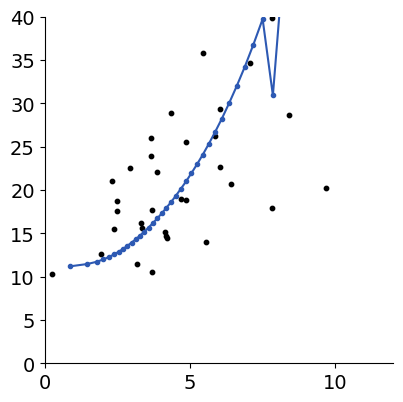

In [72]:
# non linear fit + bootstrap
%matplotlib inline
fig4, ax4 = plt.subplots(1, 1)

hires_x = np.linspace(0, 15, 1000)
func = lambda x, a, b: a*(x) + b
# best_fit_ab, covar = curve_fit(func, NDAT['ZC'][0,0].squeeze(), param_set[1][:,1],
#                                absolute_sigma = True)
best_fit_ab, covar = curve_fit(func, true_thresh, param_set[:,1],
                               absolute_sigma = True)

num_sim = int(5000)
ps = []
for i in range(num_sim):
    i_sample = np.random.choice(np.linspace(0,len(true_thresh)-1,len(true_thresh),dtype=np.int16),len(true_thresh))
    while True:
        try:
            fit_ab, covar = curve_fit(func, true_thresh[i_sample], param_set[:,1][i_sample],
                                       absolute_sigma = True, p0=[1,1], maxfev=int(1e4))
        except:
            print('redo it with different random seed.')
        break
        
    ps.append(fit_ab)
    
print(scipy.stats.pearsonr(true_thresh, param_set[:,1]))

pars_ec = ec.get_sigmoid_fits()
gain_ec = pars_ec[:, 1]

ax4.set_xticks([0, 5, 10, 20])
ysample = np.asarray([func(hires_x, *pi) for pi in ps])
lower = np.percentile(ysample, 5, axis=0)
upper = np.percentile(ysample, 95, axis=0)

#ax4.plot(hires_x, func(hires_x, *best_fit_ab), 'black', alpha=0.2)
#ax4.fill_between(hires_x, lower, upper,
#                 color = 'black', alpha=0.05)
ax4.scatter(true_thresh, param_set[:, 1], s=10, color=[0, 0, 0])
ax4.plot(thresh_ec[:-1], gain_ec[:-1], '.-', color='#2D59B3')

ax4.set_xlim(0, 12)
ax4.set_ylim(0, 40)
fig4.set_figwidth(4.5)
fig4.set_figheight(4.5)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

fig4.savefig(
    os.path.join('.', fig_folder, 'threshold-gain-fit.png'))
fig4.savefig(
    os.path.join('.', fig_folder, 'threshold-gain-fit.pdf'))

# Threshold - Asymmetry plot

PearsonRResult(statistic=0.8315029712866673, pvalue=5.547485082671957e-11)


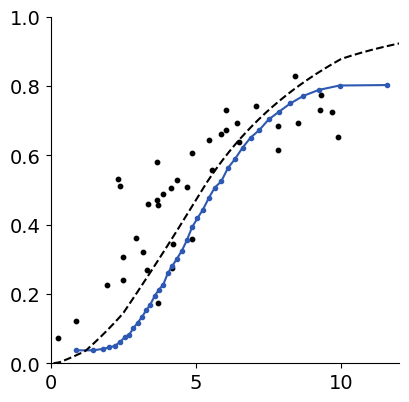

In [73]:
fig, ax = plt.subplots(1,1)
RPs = ec.get_quantiles_RPs(quantiles_ec)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.scatter(true_thresh[idx_sorted], asymM_all, s=10, color='k')
ax.plot(thresh_ec, quantiles_ec, '.-', color='#2D59B3')
ax.set_xticks([0, 5, 10, 20])
ax.set_xlim([0, 12])
ax.set_ylim([0, 1])
plt.grid(False)
fig.set_figwidth(4.5)
fig.set_figheight(4.5)

#RPSS = ec.get_quantiles_RPs(np.linspace(0,1,1000))
RPSS = np.empty(1000)
for i, q in enumerate(np.linspace(0,1,1000)):
    RPSS[i] = scipy.stats.expectile(juice_magnitudes, alpha=q, weights=juice_prob)
# ax.plot(np.linspace(0,1,1000), RPSS, '--', color=[.7,.7,.7])
ax.plot(RPSS,np.linspace(0,1,1000), '--k')

fig.savefig(
    os.path.join('.',fig_folder, 'threshold-asymm.png'))
fig.savefig(
    os.path.join('.',fig_folder, 'threshold-asymm.pdf'))


print(scipy.stats.pearsonr(true_thresh[idx_sorted], asymM_all))

# slope vs density

PearsonRResult(statistic=-0.5345962808041801, pvalue=0.00045511547703856427)
PearsonRResult(statistic=-0.9387831593774824, pvalue=1.040530922602479e-18)


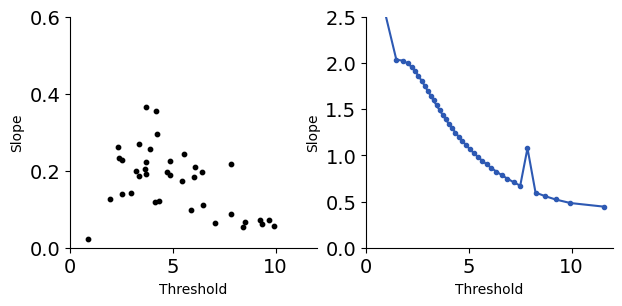

In [74]:
%matplotlib inline
# scatter plot between thresholds/midpoints and slopes
fig, ax = plt.subplots(1,2)

use_thresholds = True

pars_ec = ec.get_sigmoid_fits()
if use_thresholds:
    thresh_dat = true_thresh
    thresh_ec_local = np.array(thresh_ec)
else:
    thresh_dat = param_set[:, 2]
    thresh_ec_local = pars_ec[:, 2]
slope_dat = param_set[:, 0]
slope_ec = pars_ec[:, 0]

func = lambda x, slope, intercept: slope*(x) + intercept
num_sim = int(5e3)
ps = []
for i in range(num_sim):
    i_sample = np.random.choice(np.arange(len(thresh_dat)-1,dtype=int),len(thresh_dat))
    while True:
        try:
            # fit the line for _thresholds and _slopes
            slope, intercept, r_value, p_value, std_err = stats.linregress(thresh_dat[i_sample], slope_dat[i_sample])
        except:
            print('redo it with different random seed.')
        break

    ps.append([slope, intercept])

#slope, intercept, r_value, p_value, std_err = stats.linregress(thresh_dat, slope_dat)
#ax[0].plot([0, 12], [intercept, intercept + slope * 12], 'k', lw=2)
# bow tie shaped shaded plot for the 90% confidence interval
#ysample = np.asarray([func(np.linspace(0,12,100), *pi) for pi in ps])
#lower = np.percentile(ysample, 5, axis=0)
#upper = np.percentile(ysample, 95, axis=0)
#ax[0].fill_between(np.linspace(0,12,100), lower, upper,
#                 color = 'black', alpha = 0.15)

#ps = []
#for i in range(num_sim):
#    i_sample = np.random.choice(np.arange(len(thresh_ec),dtype=int),len(thresh_ec))
#    while True:
#        try:
#            # fit the line for _thresholds and _slopes
#            slope, intercept, r_value, p_value, std_err = stats.linregress(thresh_ec_local[i_sample], slope_ec[i_sample])
#        except:
#            print('redo it with different random seed.')
#        break

#    ps.append([slope, intercept])
#slope, intercept, r_value, p_value, std_err = stats.linregress(thresh_ec_local, slope_ec)
#ax[1].plot([0, 12], [intercept, intercept + slope * 12], '#9ebcda', lw=2)
#ysample = np.asarray([func(np.linspace(0,12,100), *pi) for pi in ps])
#lower = np.percentile(ysample, 5, axis=0)
#upper = np.percentile(ysample, 95, axis=0)
#ax[1].fill_between(np.linspace(0,12,100), lower, upper,
#                 color = '#9ebcda', alpha = 0.15)



ax[0].scatter(thresh_dat, slope_dat, s=10, color='k')
ax[1].plot(thresh_ec_local, slope_ec, '.-', color='#2D59B3')


# plt.grid(True)
fig.set_figwidth(7)
fig.set_figheight(3)

# ax.legend(['Measured neurons','Efficient code'])

# correlation analysis for r and p
from scipy.stats import pearsonr
print(pearsonr(thresh_dat, slope_dat))
print(pearsonr(thresh_ec_local, slope_ec))

for i in range(2):
    if use_thresholds:
        ax[i].set_xlabel('Threshold')
    else:
        ax[i].set_xlabel('Midpoint')
    ax[i].set_ylabel('Slope')

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    ax[i].set_xlim([0, 12])
    if i == 0:
        ax[i].set_ylim([0, 0.6])
    else:
        ax[i].set_ylim([0, 2.5])



if use_thresholds:
    fig.savefig(
        os.path.join('.', fig_folder, 'threshold-slope_model_sbs_diffaxis.png'))
    fig.savefig(
        os.path.join('.', fig_folder, 'threshold-slope_model_sbs_diffaxis.pdf'))
else:
    fig.savefig(
        os.path.join('.', fig_folder, 'midpoint-slope_model_sbs_diffaxis.png'))
    fig.savefig(
        os.path.join('.', fig_folder, 'midpoint-slope_model_sbs_diffaxis.png'))
    
plt.show()

# plot half gain and r-star


In [75]:
NDAT = sio.loadmat(dir_measured_neurons + 'data_max.mat')['dat']
data = sio.loadmat('curve_fit_parameters.mat')['ps']

In [76]:
half_gain_model = [ec.gsn[i] / 2 for i in range(len(ec.gsn))]


In [77]:


# collect b from sigmoid _func
bs = []
for i in range(len(data)):
    bs.append(data[i][1])

# half of the gain
half_gain = np.array(bs) / 2

# remove the neuron that is not valid
half_gain = np.delete(half_gain, 19)

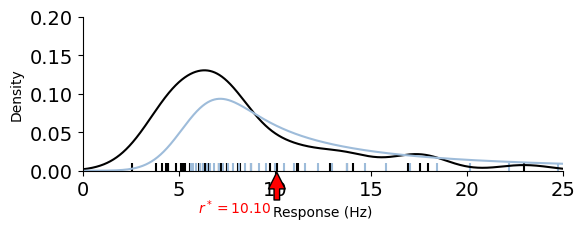

In [78]:
%matplotlib inline
# plot small ticks of half gain
fig, ax = plt.subplots(1, 1)

# vlines plot of half gain
ax.vlines(half_gain, 0, .01*np.ones(39), colors='k')
ax.vlines(half_gain_model, 0, .01*np.ones(39), colors='#9ebcda')

from scipy.stats import norm
def normal_kde(x, y, sigma, x_sample):
    """calculates a normal based kernel density estimate
    based on samples at x with weights/probabilities y evaluated at x_sample"""
    y_sample = np.zeros_like(x_sample)
    for x_i, y_i in zip(x, y):
        y_sample += (norm.pdf((x_sample - x_i) / sigma) / sigma) * y_i
    return y_sample

# plot gaussian_kde of half gain
ys = normal_kde(half_gain, np.ones(39)/39, 1.4, ec.x[:8500])
plt.plot(ec.x[:8500], ys, color='k')

# plot gaussian_kde of half_gain_model
ys = normal_kde(half_gain_model, np.ones(39)/39, 1.4, ec.x[:8500])
plt.plot(ec.x[:8500], ys, color='#9ebcda')


# plot red vertical long line on 7.666667
# ax.vlines(7.666667, 0, .2, colors='r')
# and text that sais its $r^*$
# ax.text(7.6, .16, '$r^*$', color='r')

# small red arrow on the x axis that shows r^*
ax.annotate(
    '', xy=(r_star, 0), xytext=(r_star, -.04),
    arrowprops=dict(facecolor='red', shrink=0.05))

# text right below the arrow says its $r^*$
ax.text(6, -.055, '$r^*={0:.2f}$'.format(r_star), color='r')

# xticks and yticks and labels
ax.set_xticks(np.linspace(0, 25, 6))
ax.set_yticks(np.linspace(0, .2, 5))
ax.set_xlabel('Response (Hz)')
ax.set_ylabel('Density')

# set x and y lim
ax.set_xlim(0, 25)
ax.set_ylim(0, .2)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.set_figwidth(6.2)
fig.set_figheight(2)
# write title that says it is half gain of the neurons
# plt.title('Half gain of the neurons')
plt.savefig('./figures/half_gain.png', bbox_inches='tight')
# pdf
plt.savefig('./figures/half_gain.pdf', bbox_inches='tight')

plt.show()


# thresholds & density


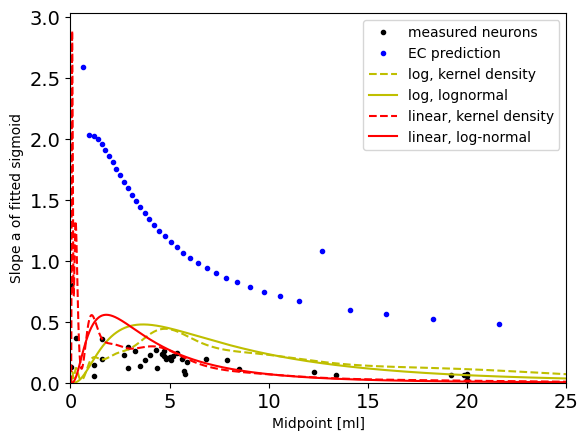

In [79]:
ec_local = value_efficient_coding_moment(
    N_neurons=N_neurons, R_t=R_t, alpha=alpha, slope_scale=slope_scale)
p_ec = ec_local.get_sigmoid_fits()
d_r = log_kde(juice_magnitudes, juice_prob, 0.3, ec.x)
plt.plot(param_set[:,2], param_set[:,0], 'k.')
plt.plot(ec_local.midpoints, p_ec[:,0], 'b.')
plt.plot(ec.x, ec.x * d_r, 'y--')
plt.plot(ec.x, ec.x * ec.p_prior, 'y-')
plt.plot(ec.x, 3* d_r, 'r--')
plt.plot(ec.x, 3* ec.p_prior, 'r-')
plt.ylabel("Slope a of fitted sigmoid")
plt.xlabel("Midpoint [ml]")
plt.xlim([0,25])
plt.ylim(bottom=0)
plt.legend(['measured neurons', 'EC prediction', 'log, kernel density', 'log, lognormal', 'linear, kernel density', 'linear, log-normal'])

# Illustration plots comparing efficient code and data 

In [80]:
from illustration_efficient import plot_optimal, make_solution, get_pars, get_optimal_single, make_efficient, make_illustration

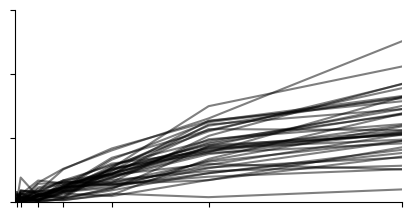

In [81]:
plt.figure(figsize=[5,2.5])
dat = sio.loadmat('measured_neurons/dat_eachneuron.mat')
dat = dat['dat']
juiceAmounts = [0.1, 0.3, 1.2, 2.5, 5, 10, 20];
y = np.array([np.nanmean(dat[0,i][0], 0) for i in range(dat.shape[1])]).T
plt.plot(juiceAmounts, y-np.min(y, 0, keepdims=True),'k-', alpha=0.5)
plt.ylim(bottom=0, top=30)
plt.xlim(left=0,right=20)
plt.xticks(juiceAmounts, labels=[])
plt.yticks([0,10,20,30], labels=[])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig("figures/raw_data.pdf")

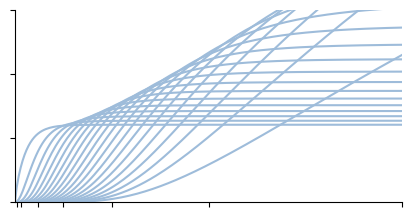

In [82]:
plt.figure(figsize=[5,2.5])
mu, sigma = get_pars()
x = np.linspace(np.finfo(float).eps, 100, 1000)
y_pdf = scipy.stats.norm.pdf(np.log(x), mu, sigma) / x
plot_optimal(plt.gca(), x, y_pdf, np.cumsum(y_pdf)/ (0.0001 + np.sum(y_pdf)), alpha, 20, mu, sigma, slope_scale=slope_scale, color='#9ebcda', R_max=R_t)
plt.ylim(bottom=0, top=30)
plt.xlim(left=0, right=20)
plt.xticks(juiceAmounts, labels=[])
plt.yticks([0,10,20,30], labels=[])
plt.savefig("figures/raw_model.pdf")

the used alpha values were:
[1, 0.8, 0.6, 0.4, 0.2]
the used mus and sigmas were:
[1.297167735050588, 1, 1.5, 2, 3]
[0.8407651464986536, 0.5, 1, 0.5, 0.25]


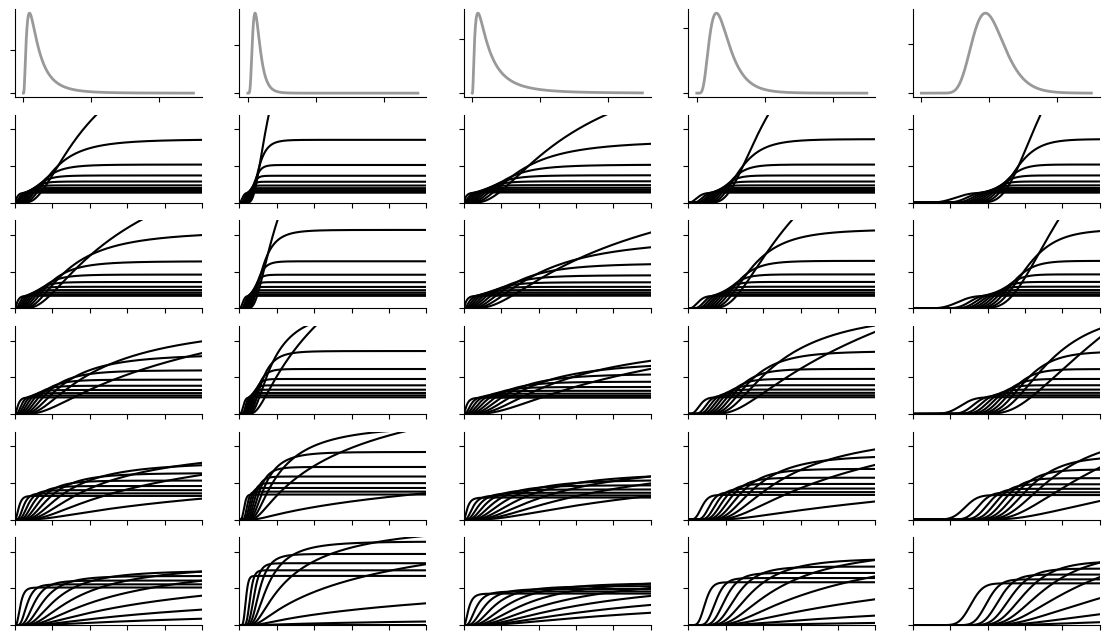

In [83]:
make_solution(slope_scale=slope_scale)
plt.savefig("figures/solution_alphas.pdf")

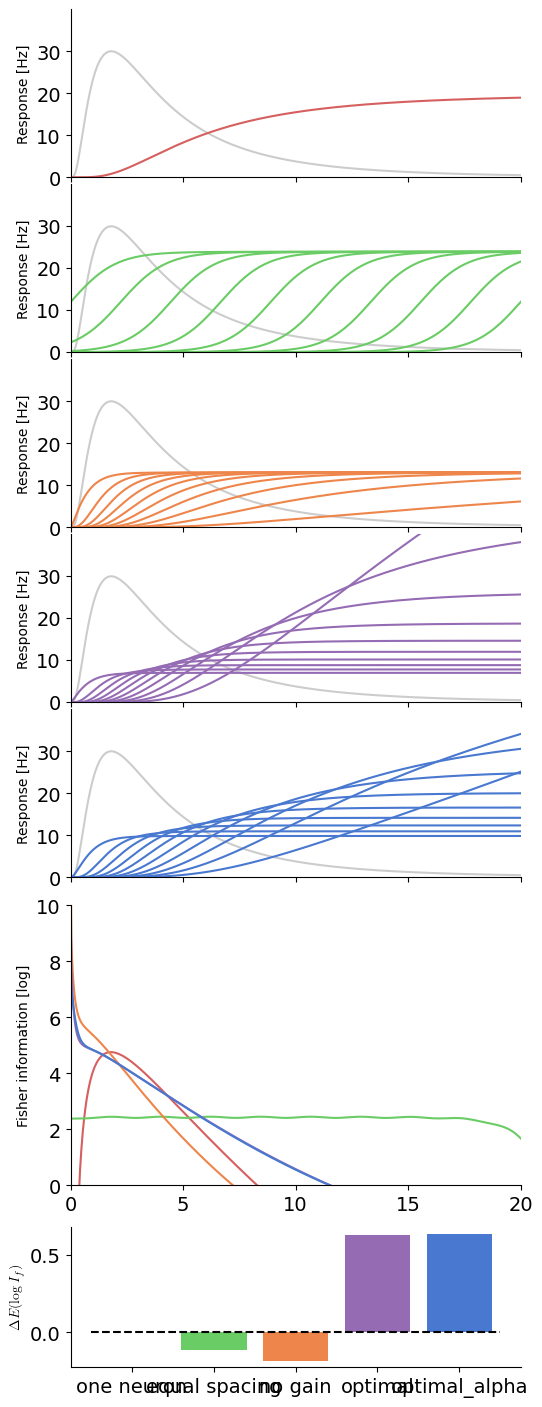

In [84]:
make_efficient(alpha=alpha, slope_scale=slope_scale, use_beta=True)
plt.savefig("figures/efficiency_comparison.pdf")

In [85]:
print(np.sum(juice_magnitudes * juice_prob))
print(np.mean(true_thresh))
print(np.mean(thresh_ec))

5.207829294078293
5.0018066407044115
4.947567099412495


In [86]:
juice_magnitudes[np.where(np.cumsum(juice_prob)>0.5)]

array([ 5., 10., 20.])

In [87]:
print(np.mean(midpoints))
print(np.mean(pars_ec[:, 2]))

6.486531338990397
5.300953279523541


(-1.0, 21.0, -1.0, 21.0)

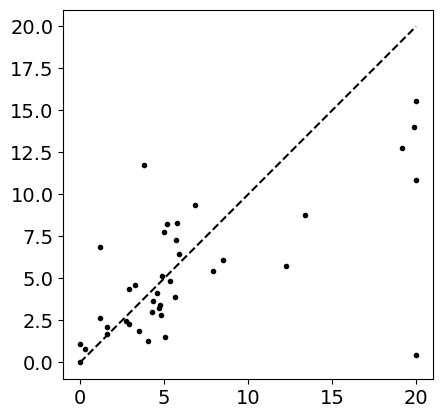

In [88]:
plt.plot(midpoints[idx_sorted], pars_ec[:,2], 'k.')
plt.plot([0,20], [0,20], 'k--')
plt.axis("square")

In [89]:
np.mean(zero_crossings_estimated)

5.659414669279384

In [90]:
np.mean(thresh_ec)

4.947567099412495

In [91]:
np.std(thresh_ec)/np.sqrt(38)

0.40142793474220234

In [92]:
scipy.stats.ttest_1samp(midpoints,np.sum(juice_magnitudes * juice_prob))

TtestResult(statistic=1.3615055023729519, pvalue=0.18137255921724044, df=38)

In [93]:
scipy.stats.ttest_1samp(true_thresh,np.sum(juice_magnitudes * juice_prob))

TtestResult(statistic=-0.5191523086563402, pvalue=0.6066652143505333, df=38)